In [0]:
import os
os.chdir("/content/drive/My Drive/ImageCaption")


In [0]:
import numpy as np
import pandas as pd
for i in range(0,150000, 15000):
  if i == 0:
    captions = np.load(f"captions{i}.npy")
  else:
    captions = np.concatenate((captions, np.load(f"captions{i}.npy")), axis = 0)

    

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions.astype(str))
len(tokenizer.word_index)


Using TensorFlow backend.


17794

In [0]:
idx = {ids: word for word, ids in tokenizer.word_index.items()}
wordx = {word : ids for word, ids in tokenizer.word_index.items()}
idx[0] = "<PAD>"
idx[17795] = "<BOS>"
idx[17796] = "<EOS>"

In [0]:
vocab_len = len(idx)

In [0]:
sequences = tokenizer.texts_to_sequences(captions.astype(str))
output_seq = []
input_seq = []
for i, seq in enumerate(sequences):
  seq.append(17796)
  output_seq.append(seq)
for i, seq in enumerate(output_seq):
  new = seq.copy()
  new.insert(0,17795)
  input_seq.append(new)

In [0]:
input_seq = np.asarray(pad_sequences(input_seq, padding = "post"))
maxlen = input_seq.shape[1]
output_seq = np.asarray(pad_sequences(output_seq, padding = "post", maxlen = maxlen))


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Sequential, Model
from keras.layers import Dense , Dropout , Lambda, Flatten, Input, Embedding, LSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical



from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Convolution2D , MaxPooling2D, Activation

In [0]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))

In [0]:
for layer in vgg.layers[:-2]:
  layer.trainable = False
h = vgg.output
h = Flatten()(h)
encoder_out_h = Dense(64, activation= 'relu')(h)
c = vgg.output
c = Flatten()(c)
encoder_out_c = Dense(64, activation= 'relu')(c)
enc_states = [encoder_out_h, encoder_out_c]

dec_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_len +1, 64)
dec_emb_out = dec_emb(dec_inputs)
dec_lstm = LSTM(64, return_sequences = True, return_state = True)
dec_out, _, _ = dec_lstm(dec_emb_out, initial_state = enc_states)
dec_soft = Dense(vocab_len+1, activation = "softmax")
dec_out = dec_soft(dec_out)
model = Model([vgg.input, dec_inputs], dec_out)
model.load_weights('best_model.h5')


In [0]:
from keras.losses import categorical_crossentropy
LR = 1e-2
model.compile(optimizer = Adam(LR), loss = categorical_crossentropy, metrics = ["accuracy"])


In [0]:
# del curroutput
# del image_array


In [0]:
from keras.utils.np_utils import to_categorical
import gc
k = 0
for i in range(0,10):
  for i in range(0,150000, 15000):
    image_array = np.load(f"images{i}.npy", mmap_mode= 'r')
    for j in range(0, 15000, 1500):
      
      curroutput = to_categorical(output_seq[j:j+1500], num_classes = vocab_len+1)
      currimages = image_array[j:j+1500]/255.
      currinput = input_seq[j:j+1500]
      k += 1500
      print(j)
      history = model.fit([currimages, currinput], curroutput, batch_size = 128, epochs = 2,validation_split = 0.05, callbacks =[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1), ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 1)])
      del history
      del currinput
      del currimages
      del curroutput
      for i in range(3): gc.collect()


    del image_array





Verbose was too long so removed it.

In [0]:
enc_model = Model(vgg.input, enc_states)
state_h_in = Input(shape = (64,))
state_c_in  = Input(shape = (64,))
dec_state_in = [state_h_in,state_c_in]
dec_emb_out_pred = dec_emb(dec_inputs) 
dec_out_pred, state_h_out, state_c_out = dec_lstm(dec_emb_out_pred, initial_state = dec_state_in)
dec_out_pred = dec_soft(dec_out_pred)
dec_model = Model([dec_inputs] + dec_state_in, [dec_out_pred, state_h_out, state_c_out])


In [0]:
def predict_caption(img):
  dec_init = enc_model.predict(np.expand_dims(img/255., axis = 0))
  dec_word = np.array([[17795]]) 
  stop = False
  caption = ""
  while not stop:
      output = dec_model.predict([dec_word] + dec_init)
      output_seq = output[0]
      new_states = output[1:]
      new_id = np.argmax(output_seq[0,-1,:])
      new_word = idx[new_id]
      

      if (new_word ==  "<EOS>" or len(caption.split()) == maxlen):
        stop = True
      else: 
        caption += new_word + " "
      dec_word = np.array([[new_id]]) 
      dec_init = new_states
  return caption

Populating the interactive namespace from numpy and matplotlib


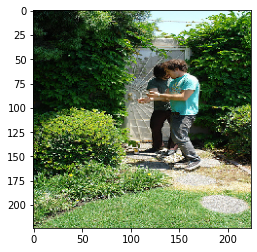

a man in a red shirt and a white shirt is standing on a bench 


In [0]:
%pylab inline
import matplotlib.pyplot as plt
image_array = np.load(f"images0.npy", mmap_mode= 'r')

img = image_array[0]
imgplot = plt.imshow(img/255.)
plt.show()
print(predict_caption(img))